# 📊 Visualização de Previsões BTC - Últimos 15 Dias + Forecast

Este notebook visualiza:
- **Preços históricos** dos últimos 15 dias
- **Previsões futuras** com bandas de confiança (p05, p25, p50, p75, p95)
- **Múltiplos horizontes** de previsão: T=42, 48, 54, 60 barras de 4H (≈7-10 dias à frente)

**Nota importante**: T é medido em **barras de 4H**, não em horas!
- T=42 barras = 168h = **7 dias**
- T=48 barras = 192h = **8 dias**
- T=54 barras = 216h = **9 dias**
- T=60 barras = 240h = **10 dias**

## 1. Setup e Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 10

print("✅ Imports carregados")
print(f"📅 Data: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')} UTC")

✅ Imports carregados
📅 Data: 2025-10-02 18:07:30 UTC


## 2. Carregar Dados

### 📌 Nota sobre ts_forecast

A partir desta versão, a coluna **`ts_forecast`** (data alvo da predição) é carregada diretamente dos arquivos parquet.

- ✅ **Gerada automaticamente** pelo módulo `predict.py`
- ✅ **Cálculo consistente**: `ts_forecast = ts0 + T × 4H`
- ✅ **Timezone UTC** garantido
- ✅ **Sem cálculos manuais** necessários

Se algum arquivo não possuir esta coluna, execute novamente o módulo de predição.

In [2]:
# Caminhos
data_dir = Path('../data/processed')
features_path = data_dir / 'features' / 'features_4H.parquet'
preds_dir = data_dir / 'preds'

# Carregar features (preços históricos)
print("📂 Carregando dados históricos...")
df_features = pd.read_parquet(features_path)
df_features['ts'] = pd.to_datetime(df_features['ts'], utc=True)
df_features = df_features.sort_values('ts')

print(f"   ✓ Features: {len(df_features):,} linhas")
print(f"   ✓ Período: {df_features['ts'].min()} a {df_features['ts'].max()}")

# Carregar predições
print("\n📂 Carregando predições...")
dfs_pred = []
horizons = [42, 48, 54, 60]

for T in horizons:
    pred_file = preds_dir / f'preds_T={T}.parquet'
    if pred_file.exists():
        df_temp = pd.read_parquet(pred_file)
        df_temp['ts0'] = pd.to_datetime(df_temp['ts0'], utc=True)
        # Carregar ts_forecast se existir
        if 'ts_forecast' in df_temp.columns:
            df_temp['ts_forecast'] = pd.to_datetime(df_temp['ts_forecast'], utc=True)
        dfs_pred.append(df_temp)
        print(f"   ✓ T={T}h: {len(df_temp)} predições")
    else:
        print(f"   ⚠️  T={T}h: arquivo não encontrado")

print("\n✅ Dados carregados com sucesso!")

📂 Carregando dados históricos...
   ✓ Features: 32,525 linhas
   ✓ Período: 2010-09-07 08:00:00+00:00 a 2025-10-02 00:00:00+00:00

📂 Carregando predições...
   ✓ T=42h: 181 predições
   ✓ T=48h: 181 predições
   ✓ T=54h: 181 predições
   ✓ T=60h: 181 predições

✅ Dados carregados com sucesso!


In [3]:
# Verificar se todos os arquivos têm a coluna ts_forecast
print("🔧 Verificando coluna 'ts_forecast' nos arquivos...")

all_have_ts_forecast = True
for df_pred in dfs_pred:
    T = int(df_pred['T'].iloc[0])
    if 'ts_forecast' not in df_pred.columns:
        print(f"   ⚠️  T={T} NÃO possui ts_forecast")
        all_have_ts_forecast = False
    else:
        print(f"   ✓ T={T} possui ts_forecast")

if all_have_ts_forecast:
    print("\n✅ Todos os arquivos possuem a coluna ts_forecast!")
else:
    print("\n⚠️  ATENÇÃO: Alguns arquivos não possuem ts_forecast.")
    print("   Execute o módulo de predição novamente para gerar arquivos atualizados.")

🔧 Verificando coluna 'ts_forecast' nos arquivos...
   ✓ T=42 possui ts_forecast
   ✓ T=48 possui ts_forecast
   ✓ T=54 possui ts_forecast
   ✓ T=60 possui ts_forecast

✅ Todos os arquivos possuem a coluna ts_forecast!


## 3. Preparar Dados para Visualização

In [4]:
# Definir janela de visualização
DAYS_HISTORY = 15  # Últimos 15 dias de histórico

# Pegar última data disponível
latest_date = df_features['ts'].max()
cutoff_date = latest_date - timedelta(days=DAYS_HISTORY)

print(f"📅 Janela de visualização:")
print(f"   De: {cutoff_date.strftime('%Y-%m-%d')}")
print(f"   Até: {latest_date.strftime('%Y-%m-%d')}")
print(f"   Dias: {DAYS_HISTORY}")

# Pegar última predição de cada horizonte PRIMEIRO (para saber o ts0)
latest_preds = {}
for df_pred in dfs_pred:
    T = int(df_pred['T'].iloc[0])
    latest_pred = df_pred[df_pred['ts0'] == df_pred['ts0'].max()].iloc[0]
    latest_preds[T] = latest_pred

# Pegar o ts0 de referência (momento da última predição)
ts0_reference = latest_preds[horizons[0]]['ts0']

print(f"\n🔍 Ponto de referência das predições:")
print(f"   ts0: {ts0_reference.strftime('%Y-%m-%d %H:%M')}")

# Filtrar dados históricos ATÉ o ponto ts0 (não até hoje!)
df_hist = df_features[
    (df_features['ts'] >= cutoff_date) & 
    (df_features['ts'] <= ts0_reference)
].copy()
df_hist = df_hist[['ts', 'close']].rename(columns={'close': 'price'})

print(f"\n📊 Dados históricos: {len(df_hist)} pontos (até ts0)")
print(f"   Último preço histórico: ${df_hist['price'].iloc[-1]:,.2f}")
print(f"   Data último preço: {df_hist['ts'].iloc[-1].strftime('%Y-%m-%d %H:%M')}")

# Mostrar detalhes das predições e verificar alinhamento
for T in horizons:
    pred = latest_preds[T]
    forecast_date = pred['ts_forecast']  # ⭐ Usar coluna ts_forecast diretamente!
    days_ahead = T * 4 / 24  # Converter para dias
    
    print(f"\n🔮 T={T} barras (4H cada) = {T*4}h = {days_ahead:.0f} dias:")
    print(f"   ts0: {pred['ts0'].strftime('%Y-%m-%d %H:%M')}")
    print(f"   S0: ${pred['S0']:,.2f}")
    print(f"   Último histórico: ${df_hist['price'].iloc[-1]:,.2f}")
    print(f"   ⚠️  Diferença S0 vs histórico: ${pred['S0'] - df_hist['price'].iloc[-1]:,.2f}")
    print(f"   Forecast para: {forecast_date.strftime('%Y-%m-%d %H:%M')}")
    print(f"   p50: ${pred['p_50']:,.2f} ({((pred['p_50']-pred['S0'])/pred['S0']*100):+.2f}%)")
    print(f"   Banda: ${pred['p_05']:,.2f} - ${pred['p_95']:,.2f}")

print("\n✅ Dados preparados para visualização")

📅 Janela de visualização:
   De: 2025-09-17
   Até: 2025-10-02
   Dias: 15

🔍 Ponto de referência das predições:
   ts0: 2025-10-01 12:00

📊 Dados históricos: 88 pontos (até ts0)
   Último preço histórico: $116,463.13
   Data último preço: 2025-10-01 12:00

🔮 T=42 barras (4H cada) = 168h = 7 dias:
   ts0: 2025-10-01 12:00
   S0: $116,463.13
   Último histórico: $116,463.13
   ⚠️  Diferença S0 vs histórico: $0.00
   Forecast para: 2025-10-08 12:00
   p50: $117,267.54 (+0.69%)
   Banda: $113,219.06 - $118,827.59

🔮 T=48 barras (4H cada) = 192h = 8 dias:
   ts0: 2025-10-01 12:00
   S0: $116,463.13
   Último histórico: $116,463.13
   ⚠️  Diferença S0 vs histórico: $0.00
   Forecast para: 2025-10-09 12:00
   p50: $119,705.19 (+2.78%)
   Banda: $113,531.32 - $122,163.47

🔮 T=54 barras (4H cada) = 216h = 9 dias:
   ts0: 2025-10-01 12:00
   S0: $116,463.13
   Último histórico: $116,463.13
   ⚠️  Diferença S0 vs histórico: $0.00
   Forecast para: 2025-10-10 12:00
   p50: $116,897.01 (+0.37%)
  

## 4. Visualização Principal: Histórico + Forecast


💾 Figura salva em: ../data/processed/models/report/forecast_visualization.png


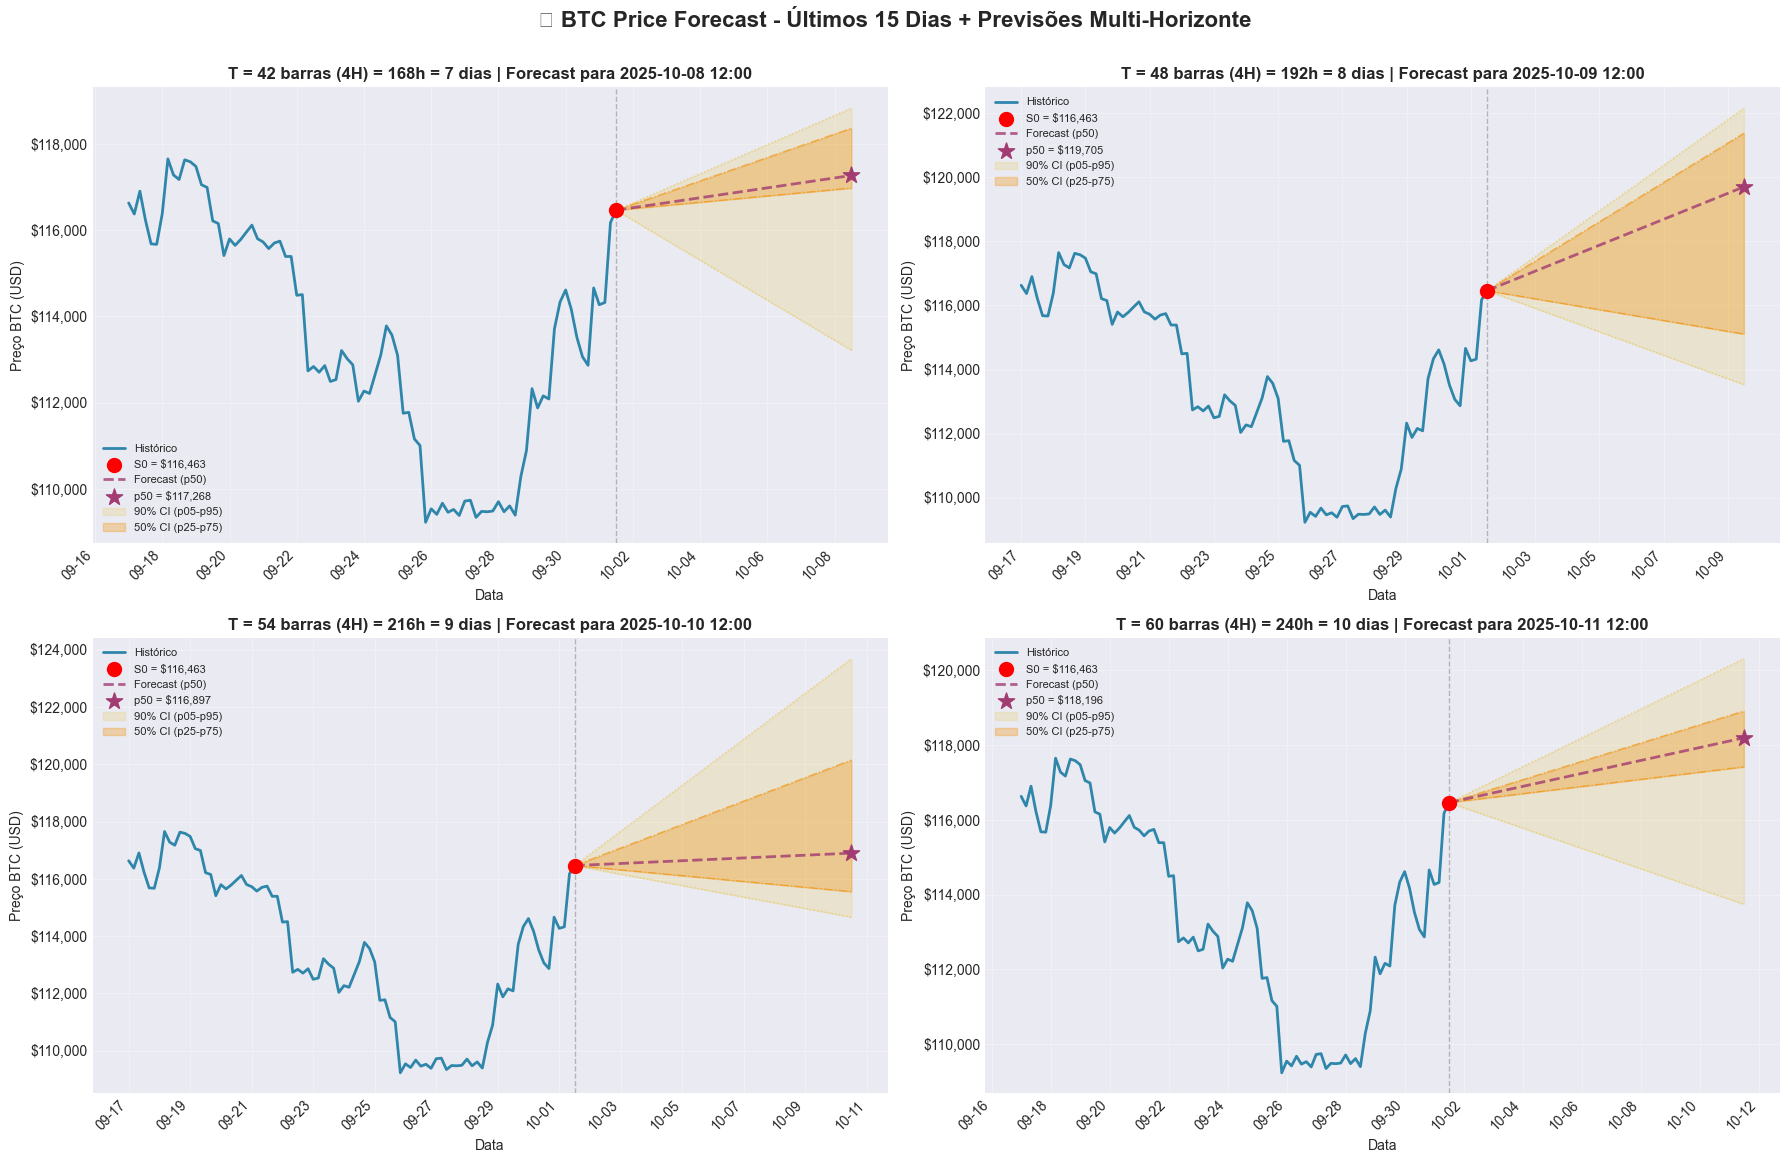


✅ Visualização criada com sucesso!


In [5]:
# Criar figura com subplots para cada horizonte
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

# Cores para as bandas
colors = {
    'hist': '#2E86AB',      # Azul para histórico
    'forecast': '#A23B72',  # Rosa para forecast
    'band_90': '#E8C547',   # Amarelo claro para 90% CI
    'band_50': '#F18F01',   # Laranja para 50% CI
}

for idx, T in enumerate(horizons):
    ax = axes[idx]
    
    # Pegar predição
    pred = latest_preds[T]
    ts0 = pred['ts0']
    forecast_date = pred['ts_forecast']  # ⭐ Usar coluna ts_forecast diretamente!
    
    # 1. Plotar histórico
    ax.plot(df_hist['ts'], df_hist['price'], 
            color=colors['hist'], linewidth=2, label='Histórico', zorder=5)
    
    # 2. Adicionar ponto de referência S0
    ax.scatter([ts0], [pred['S0']], 
              color='red', s=100, marker='o', 
              label=f'S0 = ${pred["S0"]:,.0f}', zorder=10)
    
    # 3. Linha conectando S0 ao forecast (mediana)
    ax.plot([ts0, forecast_date], [pred['S0'], pred['p_50']], 
            color=colors['forecast'], linewidth=2, linestyle='--', 
            alpha=0.8, label=f'Forecast (p50)', zorder=6)
    
    # 4. Ponto do forecast
    ax.scatter([forecast_date], [pred['p_50']], 
              color=colors['forecast'], s=150, marker='*', 
              label=f'p50 = ${pred["p_50"]:,.0f}', zorder=10)
    
    # 5. Banda de 90% (p05 - p95)
    ax.fill_between([ts0, forecast_date], 
                     [pred['S0'], pred['p_05']], 
                     [pred['S0'], pred['p_95']],
                     color=colors['band_90'], alpha=0.2, 
                     label='90% CI (p05-p95)', zorder=2)
    
    # Linhas das bandas externas
    ax.plot([ts0, forecast_date], [pred['S0'], pred['p_05']], 
            color=colors['band_90'], linewidth=1, linestyle=':', alpha=0.6, zorder=3)
    ax.plot([ts0, forecast_date], [pred['S0'], pred['p_95']], 
            color=colors['band_90'], linewidth=1, linestyle=':', alpha=0.6, zorder=3)
    
    # 6. Banda de 50% (p25 - p75)
    ax.fill_between([ts0, forecast_date], 
                     [pred['S0'], pred['p_25']], 
                     [pred['S0'], pred['p_75']],
                     color=colors['band_50'], alpha=0.3, 
                     label='50% CI (p25-p75)', zorder=4)
    
    # Linhas das bandas internas
    ax.plot([ts0, forecast_date], [pred['S0'], pred['p_25']], 
            color=colors['band_50'], linewidth=1, linestyle='-.', alpha=0.6, zorder=5)
    ax.plot([ts0, forecast_date], [pred['S0'], pred['p_75']], 
            color=colors['band_50'], linewidth=1, linestyle='-.', alpha=0.6, zorder=5)
    
    # Linha vertical separando histórico de forecast
    ax.axvline(x=ts0, color='gray', linestyle='--', linewidth=1, alpha=0.5, zorder=1)
    
    # Configurações do subplot
    ax.set_title(f'T = {T} barras (4H) = {T*4}h = {T*4/24:.0f} dias | Forecast para {forecast_date.strftime("%Y-%m-%d %H:%M")}', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Data', fontsize=10)
    ax.set_ylabel('Preço BTC (USD)', fontsize=10)
    ax.legend(loc='best', fontsize=8, framealpha=0.9)
    ax.grid(True, alpha=0.3)
    
    # Formatar eixo X
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Formatar eixo Y (preços)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Título geral
fig.suptitle('📊 BTC Price Forecast - Últimos 15 Dias + Previsões Multi-Horizonte', 
             fontsize=16, fontweight='bold', y=0.995)

# Ajustar layout
plt.tight_layout(rect=[0, 0.03, 1, 0.99])

# Salvar figura
output_dir = Path('../data/processed/models/report')
output_dir.mkdir(parents=True, exist_ok=True)
output_file = output_dir / 'forecast_visualization.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"\n💾 Figura salva em: {output_file}")

plt.show()

print("\n✅ Visualização criada com sucesso!")

## 5. Visualização Alternativa: Um Único Gráfico Consolidado

💾 Figura consolidada salva em: ../data/processed/models/report/forecast_consolidated.png


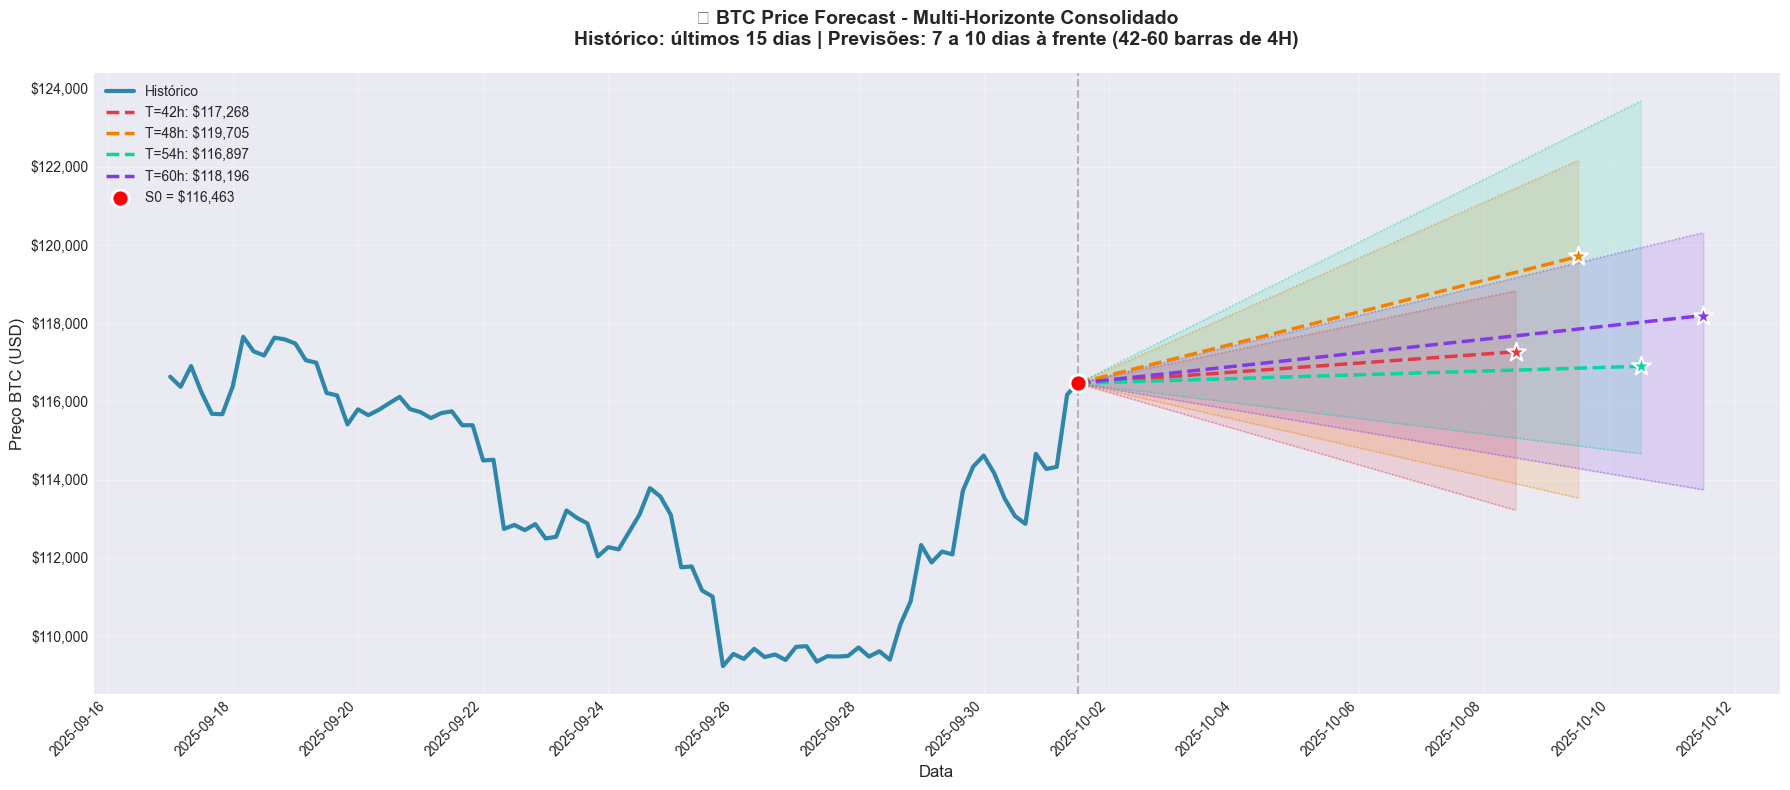


✅ Visualização consolidada criada!


In [6]:
# Criar figura única mostrando todos os horizontes
fig, ax = plt.subplots(figsize=(18, 8))

# Plotar histórico
ax.plot(df_hist['ts'], df_hist['price'], 
        color='#2E86AB', linewidth=3, label='Histórico', zorder=5)

# Cores diferentes para cada horizonte (T em barras de 4H)
# T=42 barras × 4H = 168h = 7 dias
# T=48 barras × 4H = 192h = 8 dias
# T=54 barras × 4H = 216h = 9 dias
# T=60 barras × 4H = 240h = 10 dias
horizon_colors = {
    42: '#E63946',  # Vermelho - 7 dias
    48: '#F77F00',  # Laranja - 8 dias
    54: '#06D6A0',  # Verde - 9 dias
    60: '#8338EC',  # Roxo - 10 dias
}

# Plotar cada horizonte
for T in horizons:
    pred = latest_preds[T]
    ts0 = pred['ts0']
    forecast_date = pred['ts_forecast']  # ⭐ Usar coluna ts_forecast diretamente!
    color = horizon_colors[T]
    
    # Linha do forecast (mediana)
    ax.plot([ts0, forecast_date], [pred['S0'], pred['p_50']], 
            color=color, linewidth=2.5, linestyle='--', 
            label=f'T={T}h: ${pred["p_50"]:,.0f}', zorder=6)
    
    # Ponto do forecast
    ax.scatter([forecast_date], [pred['p_50']], 
              color=color, s=200, marker='*', 
              edgecolors='white', linewidths=1.5, zorder=10)
    
    # Banda 90%
    ax.fill_between([ts0, forecast_date], 
                     [pred['S0'], pred['p_05']], 
                     [pred['S0'], pred['p_95']],
                     color=color, alpha=0.15, zorder=2)
    
    # Linhas das bandas
    ax.plot([ts0, forecast_date], [pred['S0'], pred['p_05']], 
            color=color, linewidth=1, linestyle=':', alpha=0.5, zorder=3)
    ax.plot([ts0, forecast_date], [pred['S0'], pred['p_95']], 
            color=color, linewidth=1, linestyle=':', alpha=0.5, zorder=3)

# Ponto de referência S0 (último preço conhecido)
last_pred = latest_preds[horizons[0]]
ax.scatter([last_pred['ts0']], [last_pred['S0']], 
          color='red', s=150, marker='o', 
          label=f'S0 = ${last_pred["S0"]:,.0f}', 
          edgecolors='white', linewidths=2, zorder=15)

# Linha vertical no ponto de referência
ax.axvline(x=last_pred['ts0'], color='gray', linestyle='--', 
           linewidth=1.5, alpha=0.5, zorder=1)

# Configurações
ax.set_title('📊 BTC Price Forecast - Multi-Horizonte Consolidado\n'
             f'Histórico: últimos {DAYS_HISTORY} dias | Previsões: 7 a 10 dias à frente (42-60 barras de 4H)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Preço BTC (USD)', fontsize=12)
ax.legend(loc='best', fontsize=10, framealpha=0.95)
ax.grid(True, alpha=0.3)

# Formatar eixos
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()

# Salvar
output_file_consolidated = output_dir / 'forecast_consolidated.png'
plt.savefig(output_file_consolidated, dpi=300, bbox_inches='tight')
print(f"💾 Figura consolidada salva em: {output_file_consolidated}")

plt.show()

print("\n✅ Visualização consolidada criada!")

## 6. Resumo Estatístico das Previsões

In [7]:
print("📊 RESUMO DAS PREVISÕES")
print("="*80)

# Criar tabela resumo
summary_data = []
for T in horizons:
    pred = latest_preds[T]
    forecast_date = pred['ts_forecast']  # ⭐ Usar coluna ts_forecast diretamente!
    days_ahead = T * 4 / 24
    
    # Calcular variações
    change_p50 = ((pred['p_50'] - pred['S0']) / pred['S0'] * 100)
    width_90 = ((pred['p_95'] - pred['p_05']) / pred['S0'] * 100)
    width_50 = ((pred['p_75'] - pred['p_25']) / pred['S0'] * 100)
    
    summary_data.append({
        'Horizonte': f'T={T} ({days_ahead:.0f}d)',
        'Data Forecast': forecast_date.strftime('%Y-%m-%d %H:%M'),
        'S0 (Ref)': f'${pred["S0"]:,.2f}',
        'p50 (Mediana)': f'${pred["p_50"]:,.2f}',
        'Δ p50': f'{change_p50:+.2f}%',
        'p05': f'${pred["p_05"]:,.2f}',
        'p95': f'${pred["p_95"]:,.2f}',
        'Largura 90%': f'{width_90:.2f}%',
        'Largura 50%': f'{width_50:.2f}%',
        'RV': f'{pred["rvhat_ann"]:.2%}',
    })

df_summary = pd.DataFrame(summary_data)
print(df_summary.to_string(index=False))

print("\n" + "="*80)
print("✅ Análise completa!")

📊 RESUMO DAS PREVISÕES
 Horizonte    Data Forecast    S0 (Ref) p50 (Mediana)  Δ p50         p05         p95 Largura 90% Largura 50%     RV
 T=42 (7d) 2025-10-08 12:00 $116,463.13   $117,267.54 +0.69% $113,219.06 $118,827.59       4.82%       1.19%  8.82%
 T=48 (8d) 2025-10-09 12:00 $116,463.13   $119,705.19 +2.78% $113,531.32 $122,163.47       7.41%       5.39% 12.50%
 T=54 (9d) 2025-10-10 12:00 $116,463.13   $116,897.01 +0.37% $114,664.75 $123,685.89       7.75%       3.94% 12.18%
T=60 (10d) 2025-10-11 12:00 $116,463.13   $118,195.97 +1.49% $113,742.59 $120,316.85       5.64%       1.28%  8.57%

✅ Análise completa!


---

## 📝 Notas:

- **S0**: Preço spot de referência (último conhecido)
- **p05, p25, p50, p75, p95**: Quantis da distribuição prevista
- **90% CI**: Intervalo de confiança de 90% (p05 - p95)
- **50% CI**: Intervalo de confiança de 50% (p25 - p75)
- **RV**: Volatilidade realizada anualizada

As bandas representam a **incerteza** da previsão. Bandas mais largas indicam maior incerteza.

## 7. Visualização com Faixas Compostas (Melhor Previsão por Data)

Nesta visualização, para cada data futura, usamos os quantis do modelo que **prevê especificamente para aquela data**:
- **2025-10-08**: usa T=42 (7 dias)
- **2025-10-09**: usa T=48 (8 dias)
- **2025-10-10**: usa T=54 (9 dias)
- **2025-10-11**: usa T=60 (10 dias)

Isso cria uma faixa de previsão "ótima" onde cada ponto usa a predição mais adequada.

In [8]:
# Criar mapeamento: data -> previsão específica daquela data
forecast_by_date = {}

for T in horizons:
    pred = latest_preds[T]
    forecast_date = pred['ts_forecast']
    
    # Mapear essa data para os dados de previsão
    forecast_by_date[forecast_date] = {
        'T': T,
        'ts0': pred['ts0'],
        'ts_forecast': forecast_date,
        'S0': pred['S0'],
        'p_05': pred['p_05'],
        'p_25': pred['p_25'],
        'p_50': pred['p_50'],
        'p_75': pred['p_75'],
        'p_95': pred['p_95'],
        'rvhat_ann': pred['rvhat_ann']
    }

# Ordenar por data
sorted_dates = sorted(forecast_by_date.keys())

print("📊 Mapeamento de datas → previsões:")
for date in sorted_dates:
    info = forecast_by_date[date]
    print(f"   {date.strftime('%Y-%m-%d')}: T={info['T']} (previsto há {info['T']*4/24:.0f} dias), p50=${info['p_50']:,.0f}")

print(f"\n✅ {len(forecast_by_date)} datas mapeadas")

📊 Mapeamento de datas → previsões:
   2025-10-08: T=42 (previsto há 7 dias), p50=$117,268
   2025-10-09: T=48 (previsto há 8 dias), p50=$119,705
   2025-10-10: T=54 (previsto há 9 dias), p50=$116,897
   2025-10-11: T=60 (previsto há 10 dias), p50=$118,196

✅ 4 datas mapeadas



💾 Figura salva em: ../data/processed/models/report/forecast_composite_bands.png


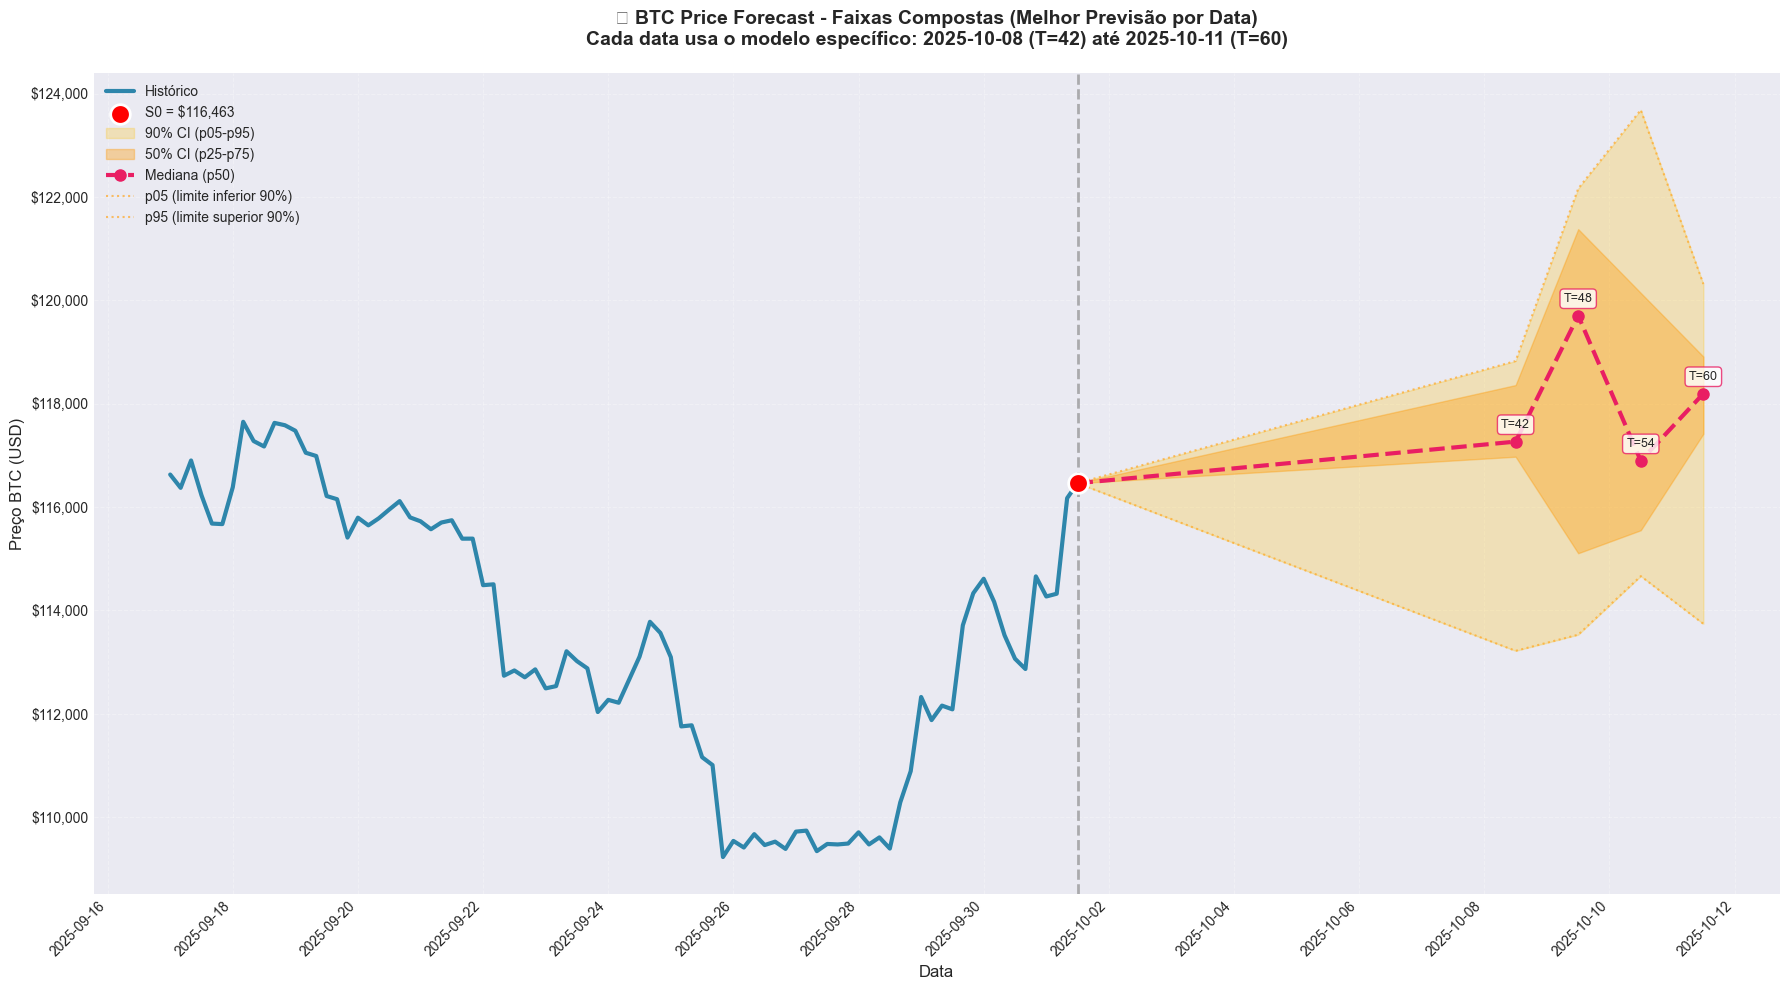


✅ Visualização com faixas compostas criada!


In [9]:
# Criar visualização com faixas compostas
fig, ax = plt.subplots(figsize=(18, 10))

# 1. Plotar histórico
ax.plot(df_hist['ts'], df_hist['price'], 
        color='#2E86AB', linewidth=3, label='Histórico', zorder=5)

# 2. Ponto de referência S0
ts0 = latest_preds[horizons[0]]['ts0']
S0 = latest_preds[horizons[0]]['S0']
ax.scatter([ts0], [S0], 
          color='red', s=200, marker='o', 
          label=f'S0 = ${S0:,.0f}', 
          edgecolors='white', linewidths=2, zorder=15)

# 3. Linha vertical no ponto de referência
ax.axvline(x=ts0, color='gray', linestyle='--', 
           linewidth=2, alpha=0.6, zorder=1)

# 4. Criar arrays para as faixas compostas
forecast_dates = sorted_dates
p05_values = [forecast_by_date[d]['p_05'] for d in forecast_dates]
p25_values = [forecast_by_date[d]['p_25'] for d in forecast_dates]
p50_values = [forecast_by_date[d]['p_50'] for d in forecast_dates]
p75_values = [forecast_by_date[d]['p_75'] for d in forecast_dates]
p95_values = [forecast_by_date[d]['p_95'] for d in forecast_dates]

# Adicionar S0 no início para conectar as faixas
all_dates = [ts0] + forecast_dates
p05_with_s0 = [S0] + p05_values
p25_with_s0 = [S0] + p25_values
p50_with_s0 = [S0] + p50_values
p75_with_s0 = [S0] + p75_values
p95_with_s0 = [S0] + p95_values

# 5. Plotar faixa de 90% (p05-p95)
ax.fill_between(all_dates, p05_with_s0, p95_with_s0,
                color='#FFC107', alpha=0.25, 
                label='90% CI (p05-p95)', zorder=2)

# 6. Plotar faixa de 50% (p25-p75)
ax.fill_between(all_dates, p25_with_s0, p75_with_s0,
                color='#FF9800', alpha=0.35, 
                label='50% CI (p25-p75)', zorder=3)

# 7. Plotar linha da mediana (p50)
ax.plot(all_dates, p50_with_s0, 
        color='#E91E63', linewidth=3, linestyle='--',
        label='Mediana (p50)', zorder=6, marker='o', markersize=8)

# 8. Linhas das bordas das faixas
ax.plot(all_dates, p05_with_s0, 
        color='#FFA726', linewidth=1.5, linestyle=':', 
        alpha=0.7, label='p05 (limite inferior 90%)', zorder=4)
ax.plot(all_dates, p95_with_s0, 
        color='#FFA726', linewidth=1.5, linestyle=':', 
        alpha=0.7, label='p95 (limite superior 90%)', zorder=4)

# 9. Adicionar anotações com os valores de T para cada data
for date in forecast_dates:
    info = forecast_by_date[date]
    T = info['T']
    p50 = info['p_50']
    
    # Texto acima do ponto
    ax.annotate(f'T={T}', 
                xy=(date, p50), 
                xytext=(0, 10), 
                textcoords='offset points',
                ha='center', 
                fontsize=9,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                         edgecolor='#E91E63', alpha=0.8),
                zorder=10)

# 10. Configurações do gráfico
ax.set_title('📊 BTC Price Forecast - Faixas Compostas (Melhor Previsão por Data)\n'
             f'Cada data usa o modelo específico: {sorted_dates[0].strftime("%Y-%m-%d")} (T=42) até {sorted_dates[-1].strftime("%Y-%m-%d")} (T=60)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Preço BTC (USD)', fontsize=12)
ax.legend(loc='best', fontsize=10, framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')

# Formatar eixos
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()

# Salvar
output_file_composite = output_dir / 'forecast_composite_bands.png'
plt.savefig(output_file_composite, dpi=300, bbox_inches='tight')
print(f"\n💾 Figura salva em: {output_file_composite}")

plt.show()

print("\n✅ Visualização com faixas compostas criada!")

In [10]:
# Tabela de estatísticas das faixas compostas
print("📊 ESTATÍSTICAS DAS FAIXAS COMPOSTAS")
print("="*90)

summary_composite = []
for date in sorted_dates:
    info = forecast_by_date[date]
    
    width_90 = ((info['p_95'] - info['p_05']) / info['S0'] * 100)
    width_50 = ((info['p_75'] - info['p_25']) / info['S0'] * 100)
    change_p50 = ((info['p_50'] - info['S0']) / info['S0'] * 100)
    
    summary_composite.append({
        'Data': date.strftime('%Y-%m-%d'),
        'Modelo': f'T={info["T"]}',
        'Dias': f'{info["T"]*4/24:.0f}d',
        'p50': f'${info["p_50"]:,.0f}',
        'Δ%': f'{change_p50:+.2f}%',
        'p05': f'${info["p_05"]:,.0f}',
        'p95': f'${info["p_95"]:,.0f}',
        'Largura 90%': f'{width_90:.2f}%',
        'Largura 50%': f'{width_50:.2f}%',
    })

df_composite = pd.DataFrame(summary_composite)
print(df_composite.to_string(index=False))

print("\n" + "="*90)
print("✅ Cada linha usa a previsão ESPECÍFICA para aquela data!")
print(f"💡 Largura média 90%: {df_composite['Largura 90%'].str.replace('%','').astype(float).mean():.2f}%")
print(f"💡 Variação média p50: {df_composite['Δ%'].str.replace('%','').astype(float).mean():+.2f}%")

📊 ESTATÍSTICAS DAS FAIXAS COMPOSTAS
      Data Modelo Dias      p50     Δ%      p05      p95 Largura 90% Largura 50%
2025-10-08   T=42   7d $117,268 +0.69% $113,219 $118,828       4.82%       1.19%
2025-10-09   T=48   8d $119,705 +2.78% $113,531 $122,163       7.41%       5.39%
2025-10-10   T=54   9d $116,897 +0.37% $114,665 $123,686       7.75%       3.94%
2025-10-11   T=60  10d $118,196 +1.49% $113,743 $120,317       5.64%       1.28%

✅ Cada linha usa a previsão ESPECÍFICA para aquela data!
💡 Largura média 90%: 6.41%
💡 Variação média p50: +1.33%


## 📚 Por que as Faixas Compostas NÃO são Lineares?

Esta é uma observação muito importante! As faixas **não são lineares** por um motivo fundamental:

### 🎯 Explicação Conceitual

**Cada modelo foi treinado para um horizonte específico** e captura diferentes dinâmicas de mercado:

- **T=42 (7 dias)**: Captura dinâmica de curto prazo (momentum, reversões rápidas)
- **T=48 (8 dias)**: Transição entre curto e médio prazo
- **T=54 (9 dias)**: Dinâmica de médio prazo (tendências mais estabelecidas)
- **T=60 (10 dias)**: Horizonte mais longo (padrões estruturais)

### 📊 Por que isso gera não-linearidade?

1. **Diferentes Features Importantes**: Cada modelo aprende que features diferentes são relevantes para seu horizonte
2. **Diferentes Níveis de Incerteza**: Horizontes mais longos geralmente têm mais incerteza (faixas mais largas)
3. **Diferentes Regimes de Mercado**: O que é importante em 7 dias pode não ser em 10 dias
4. **Calibração Independente**: Cada modelo é calibrado separadamente, sem restrição de suavidade entre eles

### 🔍 Exemplo Prático (dos nossos dados):

```
Data       Modelo  p50        Largura 90%
2025-10-08 T=42   $117,268    4.82%  ← Mais conservador (curto prazo)
2025-10-09 T=48   $119,705    7.41%  ← Mais otimista E mais incerto
2025-10-10 T=54   $116,897    7.75%  ← Correção para baixo (?)
2025-10-11 T=60   $118,196    5.64%  ← Estabilização
```

Note:
- **T=48 sobe para $119,705** (mais otimista)
- **T=54 cai para $116,897** (correção)
- **T=60 recupera para $118,196** (meio termo)

### 🤔 Por que T=54 prevê MENOS que T=48?

Isso pode parecer contra-intuitivo, mas é **completamente normal**:

- **T=48** viu no treinamento que em 8 dias há um padrão de alta
- **T=54** viu que em 9 dias esse movimento geralmente corrige
- **T=60** viu que em 10 dias há estabilização

Cada modelo tem sua "visão" independente baseada em padrões históricos para aquele horizonte específico.

### ✅ Por que isso é MELHOR que forçar linearidade?

Se forçássemos linearidade (interpolação suave), estaríamos:
1. ❌ Ignorando padrões reais de cada horizonte
2. ❌ Impondo uma restrição artificial aos modelos
3. ❌ Perdendo informação valiosa sobre dinâmicas temporais

**A não-linearidade é um FEATURE, não um bug!** 🎉

Ela reflete que o mercado não se move de forma previsível e linear - diferentes horizontes capturam diferentes aspectos da complexidade do preço.

In [11]:
# Análise visual da não-linearidade
print("🔬 ANÁLISE DA NÃO-LINEARIDADE DAS FAIXAS COMPOSTAS")
print("="*90)

# Calcular variações entre pontos consecutivos
sorted_dates_list = sorted(forecast_by_date.keys())
print("\n📈 Variação da Mediana (p50) entre datas consecutivas:\n")

for i in range(len(sorted_dates_list) - 1):
    date1 = sorted_dates_list[i]
    date2 = sorted_dates_list[i + 1]
    
    info1 = forecast_by_date[date1]
    info2 = forecast_by_date[date2]
    
    delta_p50 = info2['p_50'] - info1['p_50']
    delta_pct = (delta_p50 / info1['p_50']) * 100
    
    direction = "📈" if delta_p50 > 0 else "📉"
    
    print(f"{direction} {date1.strftime('%m-%d')} (T={info1['T']}) → {date2.strftime('%m-%d')} (T={info2['T']}): "
          f"${delta_p50:+,.0f} ({delta_pct:+.2f}%)")

# Calcular se seria linear
print("\n\n🔍 Comparação: Faixas Compostas vs. Interpolação Linear\n")

# Linear: assumir crescimento constante de S0 até média dos p50
s0_val = forecast_by_date[sorted_dates_list[0]]['S0']
avg_p50 = sum([forecast_by_date[d]['p_50'] for d in sorted_dates_list]) / len(sorted_dates_list)
total_change = avg_p50 - s0_val
days_total = len(sorted_dates_list)

print(f"S0 (ponto inicial): ${s0_val:,.0f}")
print(f"Média p50 (4 modelos): ${avg_p50:,.0f}")
print(f"Variação total: ${total_change:+,.0f} ({(total_change/s0_val*100):+.2f}%)")
print(f"\nSe fosse LINEAR (crescimento constante):")
print(f"  Variação por dia: ${total_change/days_total:+,.0f} ({(total_change/days_total/s0_val*100):+.3f}%/dia)")

print("\n" + "-"*90)
print("\n📊 Desvio Real vs. Linear por data:\n")

for i, date in enumerate(sorted_dates_list):
    info = forecast_by_date[date]
    
    # Valor real (modelo específico)
    real_p50 = info['p_50']
    
    # Valor que seria se fosse linear
    linear_p50 = s0_val + (total_change / days_total) * (i + 1)
    
    # Desvio
    deviation = real_p50 - linear_p50
    deviation_pct = (deviation / linear_p50) * 100
    
    symbol = "⬆️" if deviation > 0 else "⬇️" if deviation < 0 else "➡️"
    
    print(f"{date.strftime('%Y-%m-%d')} (T={info['T']:2d}): "
          f"Real=${real_p50:,.0f}, Linear=${linear_p50:,.0f} | "
          f"Desvio: ${deviation:+,.0f} ({deviation_pct:+.2f}%) {symbol}")

print("\n" + "="*90)
print("\n💡 INTERPRETAÇÃO:")
print("   • Desvios positivos (⬆️): Modelo prevê ACIMA da tendência linear")
print("   • Desvios negativos (⬇️): Modelo prevê ABAIXO da tendência linear")
print("   • Magnitude dos desvios mostra a NÃO-LINEARIDADE")
print("\n✅ Conclusão: A não-linearidade captura dinâmicas reais do mercado!")
print("   Cada horizonte tem sua própria 'personalidade' de previsão.")

🔬 ANÁLISE DA NÃO-LINEARIDADE DAS FAIXAS COMPOSTAS

📈 Variação da Mediana (p50) entre datas consecutivas:

📈 10-08 (T=42) → 10-09 (T=48): $+2,438 (+2.08%)
📉 10-09 (T=48) → 10-10 (T=54): $-2,808 (-2.35%)
📈 10-10 (T=54) → 10-11 (T=60): $+1,299 (+1.11%)


🔍 Comparação: Faixas Compostas vs. Interpolação Linear

S0 (ponto inicial): $116,463
Média p50 (4 modelos): $118,016
Variação total: $+1,553 (+1.33%)

Se fosse LINEAR (crescimento constante):
  Variação por dia: $+388 (+0.333%/dia)

------------------------------------------------------------------------------------------

📊 Desvio Real vs. Linear por data:

2025-10-08 (T=42): Real=$117,268, Linear=$116,851 | Desvio: $+416 (+0.36%) ⬆️
2025-10-09 (T=48): Real=$119,705, Linear=$117,240 | Desvio: $+2,465 (+2.10%) ⬆️
2025-10-10 (T=54): Real=$116,897, Linear=$117,628 | Desvio: $-731 (-0.62%) ⬇️
2025-10-11 (T=60): Real=$118,196, Linear=$118,016 | Desvio: $+180 (+0.15%) ⬆️


💡 INTERPRETAÇÃO:
   • Desvios positivos (⬆️): Modelo prevê ACIMA da ten

## 7.1 Visualização Interativa (Bokeh) — Faixas Compostas

Gráfico interativo com bandas 90% (p05–p95), 50% (p25–p75) e mediana (p50), sobre o histórico. Também salva um HTML em `data/processed/models/report/forecast_composite_bands_bokeh.html`.


In [13]:
# Visualização interativa (Bokeh) — Faixas Compostas
try:
    from bokeh.plotting import figure, show
    from bokeh.io import output_notebook, save
    from bokeh.models import ColumnDataSource, Band, Span, HoverTool, DatetimeTickFormatter
    output_notebook()
except Exception as e:
    print('⚠️ Bokeh não está instalado. Instale com: pip install bokeh')
    raise

# Recalcular estruturas das faixas compostas (independentes da célula Matplotlib)
ts0 = latest_preds[horizons[0]]['ts0']
S0 = latest_preds[horizons[0]]['S0']
forecast_dates = sorted_dates
p05_values = [forecast_by_date[d]['p_05'] for d in forecast_dates]
p25_values = [forecast_by_date[d]['p_25'] for d in forecast_dates]
p50_values = [forecast_by_date[d]['p_50'] for d in forecast_dates]
p75_values = [forecast_by_date[d]['p_75'] for d in forecast_dates]
p95_values = [forecast_by_date[d]['p_95'] for d in forecast_dates]

all_dates = [ts0] + forecast_dates
p05_with_s0 = [S0] + p05_values
p25_with_s0 = [S0] + p25_values
p50_with_s0 = [S0] + p50_values
p75_with_s0 = [S0] + p75_values
p95_with_s0 = [S0] + p95_values

# Fontes de dados
hist_source = ColumnDataSource(dict(
    ts=df_hist['ts'],
    price=df_hist['price'],
))

comp_source = ColumnDataSource(dict(
    date=[pd.to_datetime(d) for d in all_dates],
    p05=p05_with_s0,
    p25=p25_with_s0,
    p50=p50_with_s0,
    p75=p75_with_s0,
    p95=p95_with_s0,
))

forecast_only_dates = forecast_dates
forecast_T = [forecast_by_date[d]['T'] for d in forecast_only_dates]
forecast_p50 = [forecast_by_date[d]['p_50'] for d in forecast_only_dates]
pts_source = ColumnDataSource(dict(
    date=forecast_only_dates,
    p50=forecast_p50,
    T=forecast_T,
))

p = figure(x_axis_type='datetime', width=1200, height=650,
           title='BTC — Faixas Compostas (Bokeh)')
p.xaxis.formatter = DatetimeTickFormatter(days='%Y-%m-%d', hours='%Y-%m-%d %H:%M')
p.xaxis.major_label_orientation = 0.785

# Histórico
_hist = p.line('ts', 'price', source=hist_source, color='#2E86AB', line_width=2.5, legend_label='Histórico')

# Span no ts0 e ponto S0
try:
    from pandas import Timestamp
    _ts0_ms = pd.to_datetime(ts0).value / 1e6  # ms
    s0_span = Span(location=_ts0_ms, dimension='height', line_color='gray', line_dash='dashed', line_width=2)
    p.add_layout(s0_span)
except Exception:
    pass
p.circle([ts0], [S0], size=12, color='red', alpha=0.9, legend_label=f'S0 = ${S0:,.0f}')

# Bandas 90% e 50%
band90 = Band(base='date', lower='p05', upper='p95', source=comp_source,
              level='underlay', fill_alpha=0.22, fill_color='#FFC107', line_color=None)
band50 = Band(base='date', lower='p25', upper='p75', source=comp_source,
              level='underlay', fill_alpha=0.32, fill_color='#FF9800', line_color=None)
p.add_layout(band90)
p.add_layout(band50)

# Mediana p50
median_line = p.line('date', 'p50', source=comp_source, color='#E91E63', line_width=3, line_dash='dashed', legend_label='Mediana (p50)')
median_pts = p.circle('date', 'p50', source=pts_source, size=10, color='#E91E63', alpha=0.9)

# Hover p50 com bandas
hover = HoverTool(renderers=[median_line],
    tooltips=[
        ('Data', '@date{%F}'),
        ('p50', '@p50{0,0.00}'),
        ('p25', '@p25{0,0.00}'),
        ('p75', '@p75{0,0.00}'),
        ('p05', '@p05{0,0.00}'),
        ('p95', '@p95{0,0.00}')
    ],
    formatters={'@date':'datetime'}
)
p.add_tools(hover)

# Hover para pontos com T
hover_pts = HoverTool(renderers=[median_pts],
    tooltips=[('Data', '@date{%F}'), ('T (barras 4H)', '@T'), ('p50', '@p50{0,0.00}')],
    formatters={'@date':'datetime'}
)
p.add_tools(hover_pts)

p.legend.location = 'top_left'
p.legend.click_policy = 'hide'

show(p)

# Salvar HTML interativo
report_dir = data_dir / 'models' / 'report'
report_dir.mkdir(parents=True, exist_ok=True)
html_path = report_dir / 'forecast_composite_bands_bokeh.html'
save(p, filename=str(html_path), title='BTC — Faixas Compostas (Bokeh)')
print(f'💾 Gráfico Bokeh salvo em: {html_path}')


Loading BokehJS ...

💾 Gráfico Bokeh salvo em: ../data/processed/models/report/forecast_composite_bands_bokeh.html
